In [14]:
import requests
from bs4 import UnicodeDammit
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np
import geopandas as gpd
from random import randint
from IPython.display import Image
from IPython.display import IFrame
from IPython.display import display
from IPython.display import HTML

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Collecting data from the web

I use BeautifulSoup to scrape and parse the 17 pages leading to company pages.

In [3]:
drejo = requests.get("https://dreamjo.bs/hu/companies")
levesek = [soup(drejo.content, "lxml")]


In [4]:
for i in range(2,18):
    drejo = requests.get("https://dreamjo.bs/hu/companies?page=" + str(i))
    levesek.append(soup(drejo.content, "lxml"))
    

I used the firefox page inspector tool to examine source code, find the element contain the data I want to extract. I fetch the containers in a list. 

In [5]:
comp_containers = []
for page in levesek: 
    comp_containers.append(page.find_all('div', {"class" : "column grid-item"}))
    

In [59]:
sizeoflist = len(comp_containers)
print ("list elements: " + str(sizeoflist))       
rand_element = randint(0, sizeoflist)
print ("nested list elements: " + str(len(comp_containers[rand_element])))


list elements: 17
nested list elements: 24


Comp_containers is a nested list. A list of company pages, each element contains a list of the container elements extracted from that page, if I'm correct. With more experience I'm sure I will comfortably handle more complex data structures. Until then I try to stick on the safe side, using tools that I find simpler and I'm more certain about. I flat the list to a one dimenson list. 



In [15]:
containers = [item for page in comp_containers for item in page]


## The extracted data for each company:
- *Company Name*
- *Industry*
- *URL to company page*
- *City*
- *Company Size*
- *Number of open jobs*

With the Firefox tool I gathered the selectors for each data element I want to get, and did the extraction with the BeautifulSoup functions.

### Task:  Define a company class 

*figuring out how to extract the data took relatively long time. Getting know a little HTML/CSS and trial/error coding was n
necessery. So I used the lists to simplify things for testing. A company class must be created*

In [16]:
u = []
nam =[]
ind = []
jobs = []
city = []
comp_size = []
for link in containers:
    u.append(link.a.get("href"))
    nam.append(link.h1.text)
    ind.append(link.find("span", {"class" : "tag-text"}).text)
    jobs.append(int(link.find("div", {"class" : "card-image"}).text.strip()[0]))
    temp = link.find_all("a", {"class": "tag is-text tooltip"})
    city.append(temp[0].get("data-tooltip"))
    comp_size.append(temp[1].get("data-tooltip"))
    

In [18]:
col_names = ["company","url", "industry", "open_jobs", "city", "comp_size"]
colss = {"company" : nam, "url" : u, "industry" : ind, "open_jobs": jobs, "city": city, "comp_size" : comp_size }


## create a dataframe from the stuffes we scraped 

In [62]:
df = pd.DataFrame(data = colss)
print (df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 6 columns):
city         392 non-null object
comp_size    392 non-null object
company      392 non-null object
industry     392 non-null object
open_jobs    392 non-null int64
url          392 non-null object
dtypes: int64(1), object(5)
memory usage: 18.5+ KB
None


,city,comp_size,company,industry,open_jobs,url
0,Budapest,Középvállalat (< 250),Converzum - a nyelvi közösségi tér,Oktatás,1,https://dreamjo.bs/hu/company/converzum-a-nyel...
1,Budapest,Mikrovállalat (< 10),The WorkLife Company,"Emberi erőforrás, HR",2,https://dreamjo.bs/hu/company/the-worklife-com...
2,Budapest,Kisvállalat (< 50),APFM-Systems,Szoftverfejlesztés,0,https://dreamjo.bs/hu/company/apfm-systems
3,Budapest,Középvállalat (< 250),Webtown,Szoftverfejlesztés,2,https://dreamjo.bs/hu/company/webtown
4,Budapest,Mikrovállalat (< 10),Brokerchooser,"Pénzügy, Könyvelés",0,https://dreamjo.bs/hu/company/brokerchooser


## Scrape the company pages

Using the same method as before with the extracted URL-s, we can scrape the company pages. At the same time, I save every downloaded page in different files for backup, because I don't want to dowload 400 pages again if I mess something up.

In [65]:
masodikok = []
i=0
for page in df.url:
    drejo = requests.get(page)
    masodikok.append(soup(drejo.content, "lxml"))
    with open("dreamjobs2/page{}.html".format(i), "x", encoding="utf-8") as file:
        file.write(str(masodikok[i]))
    i+=1
    

The company pages have similar structures, containers (named: cards) placed on a grid. But every card can contain any kind of information, most of them are texts, which leaves us limited options for exact data that every company shares. It would be fun to analyse the text and compare the buzzword and cliche usage of companies, but that has to be done well, I need to improve my skillset for that kind of job.

I choosed to extract the office addresses. That will be good to do some visualizations. From the location distribution I may get a good picture about the areas I will most likely work.

In [ ]:
#There are pages in english and hungarian

cimek = []
for page in masodikok:
    try:
        cim = page.find("h1", string="Iroda cím").parent  
        cimek.append([page.h1.text,  cim.h2.text])
    except AttributeError:
        cim = page.find("h1", string="Office address").parent
        cimek.append([page.h1.text , cim.h2.text])
        

Update the dataframe with the addresses column by joining the new data on the company column, then tidy up a little and create a backup.

In [75]:
temp_df = pd.DataFrame(cimek, columns=["company", "address"])
df = df.merge(temp_df, on="company")
df.head()


,city,comp_size,company,industry,open_jobs,url,address
0,Budapest,Középvállalat (< 250),Converzum - a nyelvi közösségi tér,Oktatás,1,https://dreamjo.bs/hu/company/converzum-a-nyel...,"Budapest, Lajos u. 11-15, 1023 Magyarország"
1,Budapest,Mikrovállalat (< 10),The WorkLife Company,"Emberi erőforrás, HR",2,https://dreamjo.bs/hu/company/the-worklife-com...,"Budapest, Bem József u. 6, 1027 Magyarország"
2,Budapest,Kisvállalat (< 50),APFM-Systems,Szoftverfejlesztés,0,https://dreamjo.bs/hu/company/apfm-systems,"Budapest, Kacsa u., 1027 Magyarország"
3,Budapest,Középvállalat (< 250),Webtown,Szoftverfejlesztés,2,https://dreamjo.bs/hu/company/webtown,"Budapest, Hauszmann Alajos u. 3b, 1117 Magyaro..."
4,Budapest,Mikrovállalat (< 10),Brokerchooser,"Pénzügy, Könyvelés",0,https://dreamjo.bs/hu/company/brokerchooser,"Budapest, Nádor u. 9, 1051 Hungary, Central Eu..."


In [79]:
for col in ['city', 'comp_size', 'industry']:
    df[col] = df[col].astype('category')
    
size_dict = { "Kisvállalat (< 50)" : "kis", "Mikrovállalat (< 10)" : "mikro", 
    "Középvállalat (< 250)" : "közép", "Nagyvállalat (> 250)" : "nagy"}

df.comp_size.replace(size_dict, inplace=True)
df.to_csv("jobboard")


In [7]:
#checkpoint
df = pd.read_csv("jobboard")
df = df.drop('Unnamed: 0', axis=1)


The first cut eliminates every city but the No1 seed Budapest from the game.
**Budaörs**, **Budakeszi** and **Budakalász** all get a wild card spot, as outsiders these places might have 
some suprising upsides on the others.

In [10]:
fil1 = df["city"].isin(['Budapest','Budaörs', 'Budakeszi', 'Budakalász'])

df.city.value_counts().head(10)


Budapest          314
Debrecen           11
Szeged              9
Pécs                6
Kaposvár            4
Székesfehérvár      4
Budaörs             4
Miskolc             3
Budakeszi           3
Győr                3
Name: city, dtype: int64

At this point I found out plotting locations on a map won't be as easy as I tought. 
- First thing is, the address in this format is useless for me, I need the H/L coordinates of the location.
- Second, I have to find a scheme file of the area I want to plot locations on.

Before I went too deep in geography and cartography, I found a site (https://batchgeo.com/) which seemed like can handle my data and draw nice map for me, and luckily it worked.

The site can handle 250 records for free. So I made the second cut, sorting out the industries I'm least interested in, as well as every multinational company. I'm pretty sure no one is reading this, so I don't expect this can hurt my chances in the future with these companies.


In [11]:
bp = df[fil1]

fil2 = ((bp.industry != "Pénzügy, Könyvelés") & 
       (bp.industry != "Ingatlan, Építőipar") & 
       (bp.industry != "Emberi erőforrás, HR") & 
        (bp.industry != "Egyéb") &
       (bp.comp_size != "nagy"))


#the last four just doesn't fit in the 250 limit. Create a csv file for uploading the data to batchgeo
bp = bp[fil2][:-4]
bp.to_csv("bp")


In [ ]:
#Just strarting to discover the markdown cell, trying out a few things. 
#This code translates the dataframe to a html code which I to recreate the dataframe in the markdown cell. 

str(bp[bp["company"].isin(["Dyntell Software", "Antavo", "Drops"])][["company","city", "address"]].to_html()).replace("\n", "")

<div align="center">
   <h4>There was 3 companies where the address doesn't match the city. Cut them out</h4>
</div>

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>company</th>      <th>city</th>      <th>address</th>    </tr>  </thead>  <tbody>    <tr>      <th>117</th>      <td>Drops</td>      <td>Budapest</td>      <td>J. Vilmsi 11, 10126 Tallinn, Estonia</td>    </tr>    <tr>      <th>283</th>      <td>Antavo</td>      <td>Budakeszi</td>      <td>Szeged, Szentháromság u. 8, 6722 Hungary</td>    </tr>    <tr>      <th>370</th>      <td>Dyntell Software</td>      <td>Budapest</td>      <td>Debrecen, Csapó u. 28, 4024 Magyarország</td>    </tr>  </tbody></table>



In [13]:
bp = bp[~bp["company"].isin(["Dyntell Software", "Antavo", "Drops"])]
bp.to_csv("bp", index_label="index")


The cell below contains the batchgeo map embedded. It works fine in Jupiter notebook, I will search how to fix it for github.
https://batchgeo.com/map/a7b98abbff804e8ac0425836decf3a88



In [311]:
HTML('<p><iframe src="//batchgeo.com/map/a7b98abbff804e8ac0425836decf3a88" frameborder="0" width="100%" height="550" style="border:1px solid #aaa;"></iframe></p><p><small>View <a href="https://batchgeo.com/map/a7b98abbff804e8ac0425836decf3a88">Map of the week</a> in a full screen map</small></p>')

So we have a fancy <a href = 'https://batchgeo.com/map/a7b98abbff804e8ac0425836decf3a88'>map</a> with some data and a nice and simple UI. Updating and making improvements will take much less time and effort now. I might find it useful when I start applying to jobs. Combining it with data about housing oppurtunities could be a good idea. Finding a good place to work and live is my top priority right now. The combined data of two different but correlating fields can be great for practicing data analysis.

A KML file can be downloaded from Batchgeo, which has the the H/L coordinates for the locations, so I can use that data to try out some map visualisations in python. The file can be opened after enabling the driver for it.

In [221]:
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

#These are shape files I found for Budapest, it contains the cordinates for each district's borders
pest = gpd.read_file("admin_9/admin_9.shp")
pest2 =gpd.read_file("admin_9/admin_9.shx") 


In [222]:
#read the kml file to get the coordinates and prepare for join
cord_df = gpd.read_file("Mapoftheweek.kml")
cord_df = cord_df.rename(columns={'Name':'company'})
cord_df = cord_df[["company", "geometry"]]


I want to keep the **bp** dataframe in it's current state for now, so another one is created to work with. The new is going to be a GeoDataFrame

In [319]:
mapdata = cord_df.merge(bp, on="company")
mapdata.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 245 entries, 0 to 244
Data columns (total 8 columns):
company      245 non-null object
geometry     245 non-null object
city         245 non-null object
comp_size    245 non-null object
industry     245 non-null object
open_jobs    245 non-null int64
url          245 non-null object
address      245 non-null object
dtypes: int64(1), object(7)
memory usage: 17.2+ KB


Convert columns to category type, and make the company size categories ordered 

In [260]:
mapdata['comp_size']= mapdata.comp_size.astype("category")
mapdata['comp_size']= mapdata.comp_size.cat.set_categories(["mikro", "kis", "közép"],ordered=True)
mapdata["industry"] = mapdata.industry.astype("category")


The dataframe gets a new column, values representing the district the company located in. 
I'm using 2 for loops for building up a list of company-district pairs. For every dictrict the inner loop checks every office location if it's in the actual district. I'm not proud of this method, escpecially because I'm almost certain that I solved same kind of problem in the past with an elegant pandas function I forgot. 

In [261]:
a=[]

for i, district in pest.iterrows():
    for y, row in mapdata.iterrows():
        if district.geometry.contains(row.geometry):
            a.append([row.company, district.NAME])

districts = pd.DataFrame(a,columns=["company", "district"])
mapdata = mapdata.merge(districts, on="company")


The other dataframe also gets a new column, the value show the number of companies in the district

In [241]:
pest["No_comp"] = 0
pest["No_comp"] = pest["NAME"].map(dict(mapdata.district.value_counts()))
pest["No_comp"] = pest.No_comp.fillna(0)


In [242]:
pest.sort_values("No_comp",ascending=False, inplace=True)
pest.head()


,NAME,geometry,No_comp
0,XI. kerület,"POLYGON ((19.0314497 47.4867427, 19.0314903 47...",41.0
2,XIII. kerület,"POLYGON ((19.0799768 47.521701, 19.0798413 47....",34.0
21,VI. kerület,"POLYGON ((19.0591961 47.5150727, 19.0593236 47...",31.0
10,V. kerület,"POLYGON ((19.0600033 47.4943506, 19.0608794 47...",25.0
4,II. kerület,"POLYGON ((19.0085159 47.5099803, 19.0075566 47...",24.0


# Visualizations

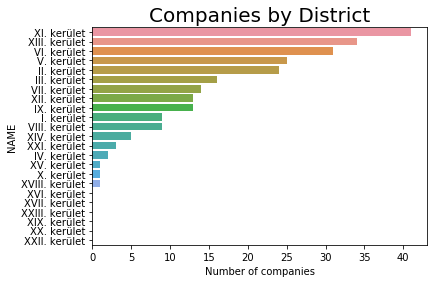

In [301]:
viz1 = sns.barplot( x=pest.No_comp, y=pest.NAME)
viz1.set_title("Companies by District", {"fontsize": 20})
viz1.set_xlabel('Number of companies')

plt.show()

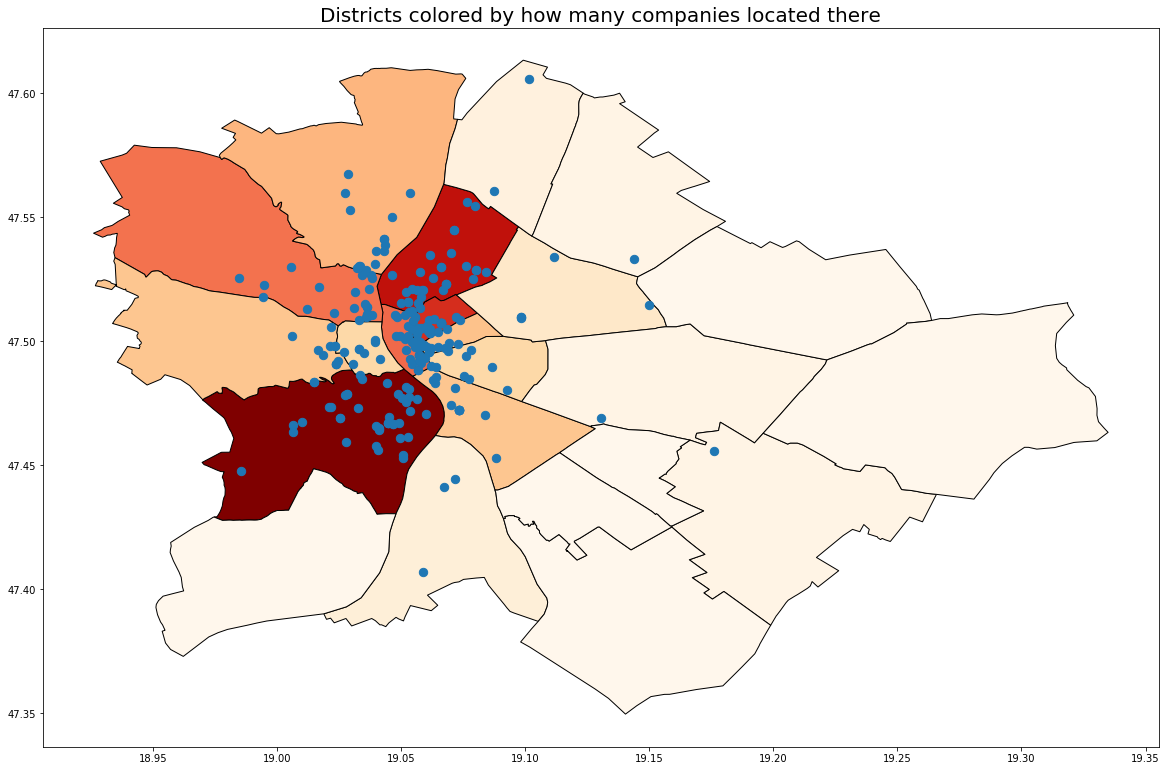

In [300]:
ax = pest.plot(figsize =(20,16) ,column="No_comp", cmap="OrRd", edgecolor = "black")
mapdata.plot(ax= ax, markersize=70)
ax.set_title("Districts colored by how many companies located there", {"fontsize": 20})

plt.show()

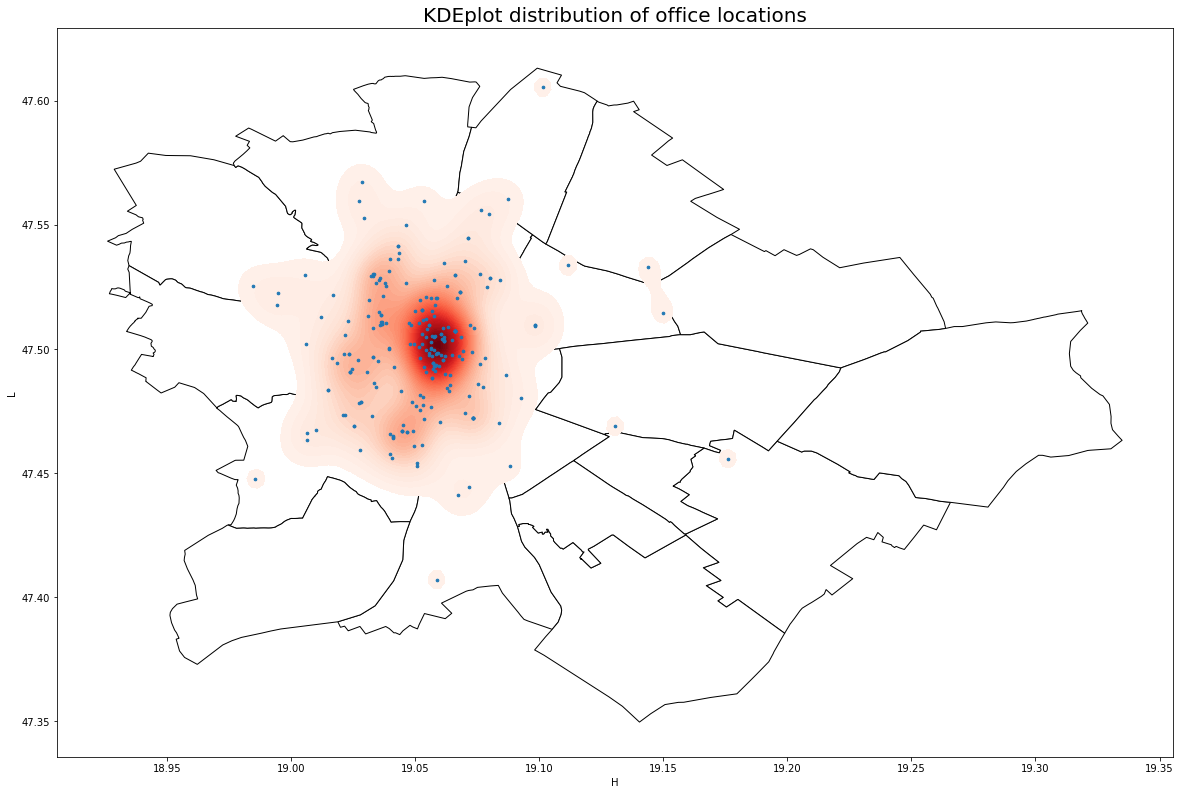

In [306]:
rajz = pest.plot(figsize= (20,16), color = "white",edgecolor = "Black")

sns.kdeplot(ax = rajz, data=temp.H, data2=temp.L,cmap="Reds",n_levels=60, shade=True, shade_lowest=False)
rajz.scatter(x=temp.H, y= temp.L, s = 7, data= temp)
rajz.set_title("KDEplot distribution of office locations", {"fontsize": 20})
plt.show()